In [1]:
%matplotlib inline

import sys
sys.path.append('../src/')

import warnings
warnings.filterwarnings('ignore')

import cv2
import torch
import wider_dataset
import choke_point_dataset

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

from benchmark.models import Detector
from benchmark.core import TsvHandle, run_detection, run_detection_video
from benchmark.stats import calc_precision_recall, calc_ap

# https://github.com/AyushExel/ml4face-detection/blob/master/Final-Face%20Detection%20Notebook.ipynb
# https://learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/
import dlib

# Dlib HoG Image detection

In [2]:
train, test, validation = tfds.load('wider_dataset', split=['train', 'test', 'validation'])
data = validation.take(2)

In [3]:
class DlibHogDetector(Detector):
    def __init__(self):
        self.detector = dlib.get_frontal_face_detector()
        
    def detect(self, image):
        boxes = []
        confidence = []
        
        dets, scores, idx = self.detector.run(image, 1, -1)
        for i, d in enumerate(dets):
            if scores[i] > 0:
                x = d.left()
                y = d.top()
                x1 = d.right()
                y1 = d.bottom()
                
                boxes.append([x, y, x1, y1])
                confidence.append(scores[i])
        
        return boxes, confidence
    
dlib_hog = DlibHogDetector()

In [4]:
with TsvHandle('hog') as tsv:
    path, ap_path, load_path, meta_path = run_detection(
        tsv_handle = tsv, 
        samples = data, 
        detector = dlib_hog,
        cv2_filter = cv2.COLOR_RGB2GRAY
    )

print("")
print(path)
print(ap_path)
print(load_path)
print(meta_path)

Running detection
[====================] 100% [2/2]
./results/hog-20220613-172539.tsv
./results/hog-20220613-172539-ap.tsv
./results/hog-20220613-172539-load.tsv
./results/hog-20220613-172539-metadata.tsv


In [5]:
with TsvHandle('hog_filtered') as tsv:
    path_filtered, ap_path_filtered, load_path_filtered, meta_path_filtered = run_detection(
        tsv_handle = tsv, 
        samples = data, 
        detector = dlib_hog,
        filter_area = 2000
    )

print("")
print(path_filtered)
print(ap_path_filtered)
print(load_path_filtered)
print(meta_path_filtered)

Running detection
[====================] 100% [2/2]
./results/hog_filtered-20220613-172604.tsv
./results/hog_filtered-20220613-172604-ap.tsv
./results/hog_filtered-20220613-172604-load.tsv
./results/hog_filtered-20220613-172604-metadata.tsv


# Results

In [6]:
df = pd.read_csv(path, sep='\t', header=0, parse_dates=["Timestamp"])
df_filtered = pd.read_csv(path_filtered, sep='\t', header=0, parse_dates=["Timestamp"])

df_ap = pd.read_csv(ap_path, sep='\t', header=0)
df_ap = df_ap.sort_values(by=['Confidence'], ignore_index=True, ascending=False)

df_ap_filtered = pd.read_csv(ap_path_filtered, sep='\t', header=0)
df_ap_filtered = df_ap_filtered.sort_values(by=['Confidence'], ignore_index=True, ascending=False)

df_load = pd.read_csv(load_path, sep='\t', header=0, parse_dates=["Timestamp"])
df_meta = pd.read_csv(meta_path, sep='\t', header=0)

In [7]:
df_meta

,Python,CPU,GPUs
0,3.8.13.final.0 (64 bit),AMD Ryzen 7 2700X Eight-Core Processor,"['device: 0, name: NVIDIA GeForce GTX 1080 Ti,..."


In [8]:
df_load

,Timestamp,CPU_Load,RAM_Avail
0,2022-06-13 17:25:39.483430,14.5,5237989376
1,2022-06-13 17:25:50.844428,12.9,4780847104


In [9]:
def plot_data_over_time(time, data, label):
    plt.plot(time, data)
    plt.xlabel('Time') 
    plt.ylabel(label)
    plt.grid(True)
    plt.show()

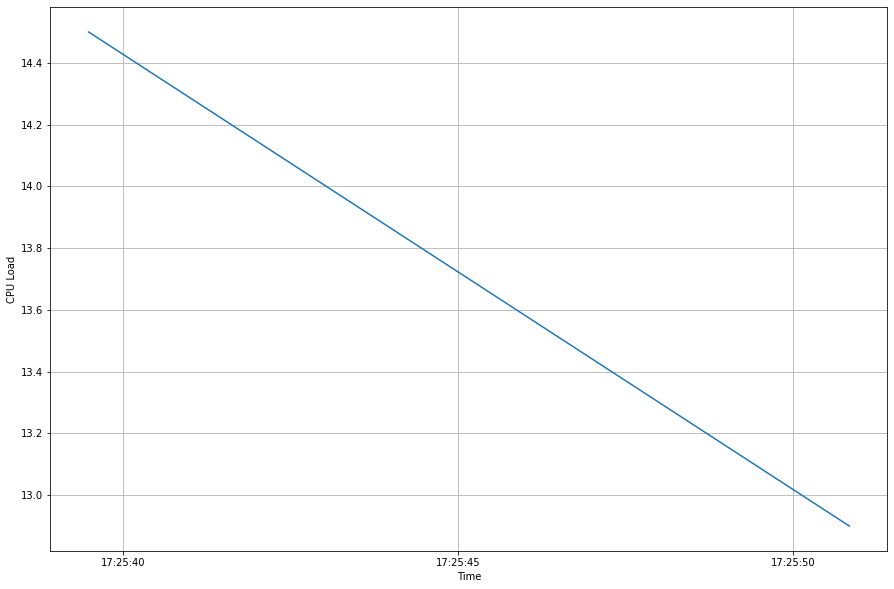

In [10]:
plot_data_over_time(df_load['Timestamp'], df_load['CPU_Load'], 'CPU Load')

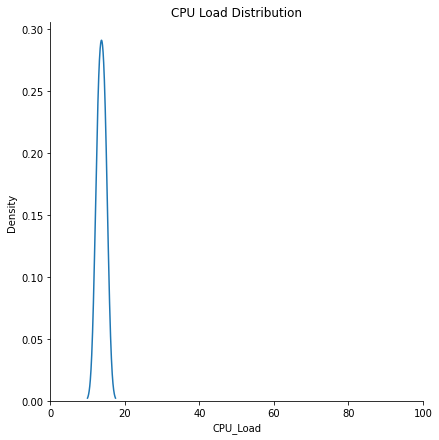

In [11]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'CPU_Load').add_legend()
plt.title('CPU Load Distribution')
plt.xlim(0, 100)
plt.show()

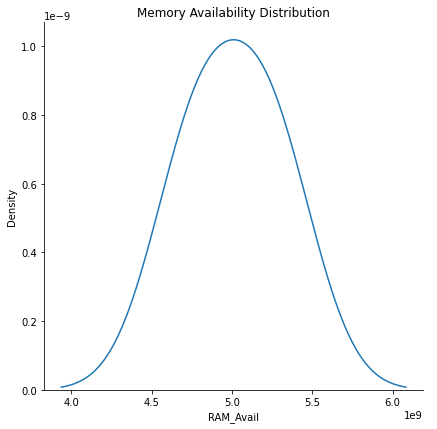

In [12]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'RAM_Avail').add_legend()
plt.title('Memory Availability Distribution')
plt.show()

In [13]:
df

,Timestamp,Speed,Precision,Recall,F1_Score,Ious,Positives,False_Positives,Negatives,Num_Of_Faces,Predicted,Ground_Truth
0,2022-06-13 17:25:40.244431,266345300,1.0,0.375,0.545455,"[0.5948354430379746, 0.7405478595979585, 0.545...",3,0,5,8,"[(763.0, 196.0, 852.0, 285.0), (175.0, 146.0, ...","[(909.0, 335.0, 974.0, 418.0), (786.0, 187.0, ..."
1,2022-06-13 17:25:40.824929,574645600,0.0,0.000,0.000000,[],0,0,1,1,[],"[(547.0, 1228.0, 688.0, 1333.0)]"


In [14]:
df.describe()

,Speed,Precision,Recall,F1_Score,Positives,False_Positives,Negatives,Num_Of_Faces
count,2.000000e+00,2.000000,2.000000,2.000000,2.00000,2.0,2.000000,2.000000
mean,4.204954e+08,0.500000,0.187500,0.272727,1.50000,0.0,3.000000,4.500000
std,2.180012e+08,0.707107,0.265165,0.385695,2.12132,0.0,2.828427,4.949747
min,2.663453e+08,0.000000,0.000000,0.000000,0.00000,0.0,1.000000,1.000000
25%,3.434204e+08,0.250000,0.093750,0.136364,0.75000,0.0,2.000000,2.750000
50%,4.204954e+08,0.500000,0.187500,0.272727,1.50000,0.0,3.000000,4.500000
75%,4.975705e+08,0.750000,0.281250,0.409091,2.25000,0.0,4.000000,6.250000
max,5.746456e+08,1.000000,0.375000,0.545455,3.00000,0.0,5.000000,8.000000


In [15]:
speed = df['Speed'].div(1e6).round(2)
speed.describe()

count      2.000000
mean     420.500000
std      218.001021
min      266.350000
25%      343.425000
50%      420.500000
75%      497.575000
max      574.650000
Name: Speed, dtype: float64

### Generate Precision/Recall columns

In [16]:
all_gts = df['Positives'].sum() + df['Negatives'].sum()
df_ap = calc_precision_recall(df_ap, all_gts)

df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,2.596913,True,True,False,1.0,0.111111,1.0,0.111111,0.0,0.0
1,1.230649,True,True,False,1.0,0.222222,1.0,0.222222,0.0,0.0
2,0.040279,True,True,False,1.0,0.333333,1.0,0.333333,0.0,0.0


In [17]:
all_gts_filtered = df_filtered['Positives'].sum() + df_filtered['Negatives'].sum()
df_ap_filtered = calc_precision_recall(df_ap_filtered, all_gts_filtered)

df_ap_filtered

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,2.585523,True,True,False,1.0,0.111111,1.0,0.111111,0.0,0.0
1,1.517644,True,True,False,1.0,0.222222,1.0,0.222222,0.0,0.0
2,0.339867,True,True,False,1.0,0.333333,1.0,0.333333,0.0,0.0


In [18]:
def plot_pr(df_data, title):
    ap = calc_ap(df_data['Precision@25'], df_data['Recall@25'])
    plt.plot(df_data['Recall@25'], df_data['Precision@25'], color='darkcyan', lw=3, label="AP@0.25=%.2f" % ap)
    plt.axvline(x = df_data['Recall@25'][df_data.index[-1]], ymax=df_data['Precision@25'][df_data.index[-1]], color = 'darkcyan')
    
    ap = calc_ap(df_data['Precision@50'], df_data['Recall@50'])
    plt.plot(df_data['Recall@50'], df_data['Precision@50'], color='darkorange', lw=3, label="AP@0.5=%.2f" % ap)
    plt.axvline(x = df_data['Recall@50'][df_data.index[-1]], ymax=df_data['Precision@50'][df_data.index[-1]], color = 'darkorange')
    
    ap = calc_ap(df_data['Precision@75'], df_data['Recall@75'])
    plt.plot(df_data['Recall@75'], df_data['Precision@75'], color='mediumorchid', lw=3, label="AP@0.75=%.2f" % ap)
    plt.axvline(x = df_data['Recall@75'][df_data.index[-1]], ymax=df_data['Precision@75'][df_data.index[-1]], color = 'mediumorchid')
    
    plt.xlim(0, 1.00)
    plt.ylim(0, 1.00)

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right", prop={'size': 16})
    plt.grid(True)

    plt.show()

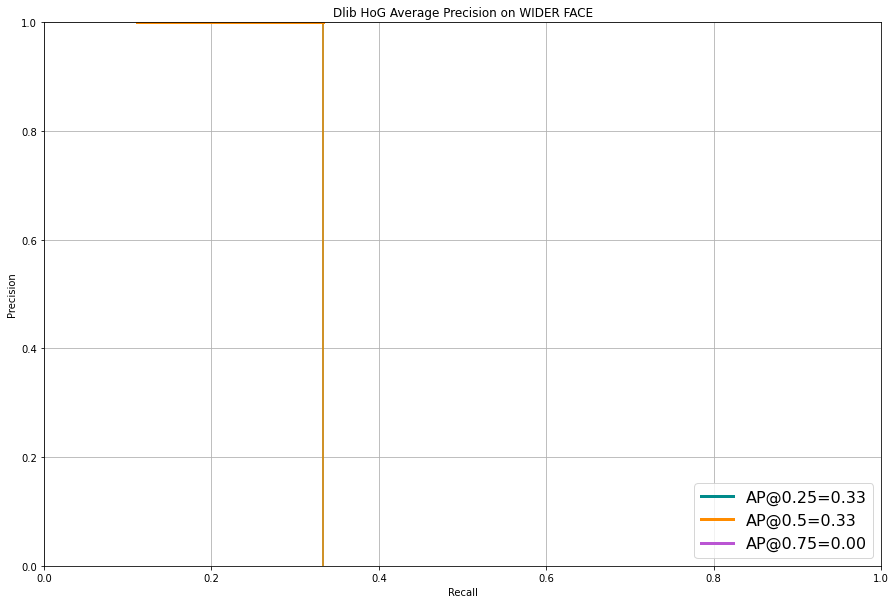

In [19]:
plot_pr(df_ap, 'Dlib HoG Average Precision on WIDER FACE')

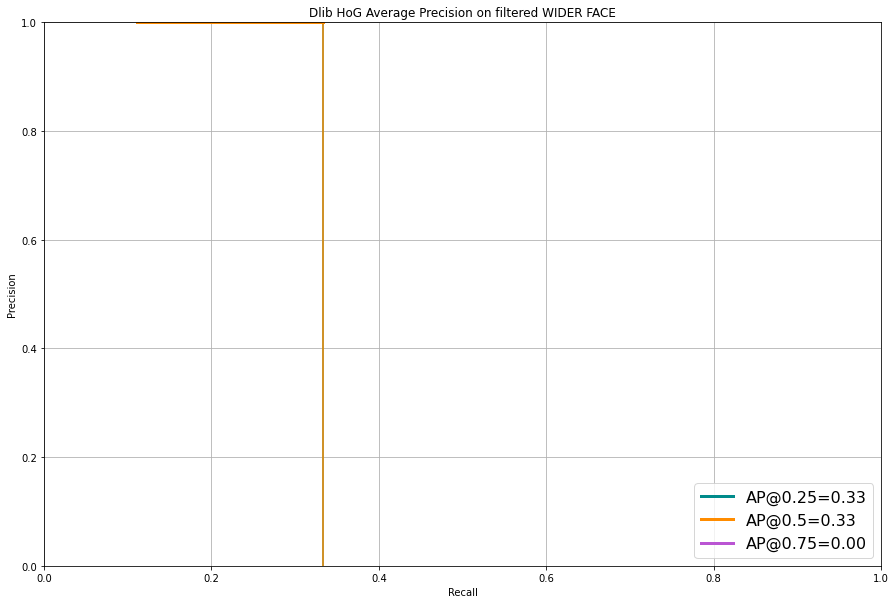

In [20]:
plot_pr(df_ap_filtered, 'Dlib HoG Average Precision on filtered WIDER FACE')

# Dlib HoG Video detection

In [21]:
test = tfds.load('choke_point', split=['test'])

In [22]:
data = test[0].take(2)

In [23]:
class DlibHogDetector(Detector):
    def __init__(self):
        self.detector = dlib.get_frontal_face_detector()
        
    def detect(self, image):
        boxes = []
        confidence = []
        
        dets, scores, idx = self.detector.run(image, 1, -1)
        for i, d in enumerate(dets):
            if scores[i] > 0:
                x = d.left()
                y = d.top()
                x1 = d.right()
                y1 = d.bottom()
                
                boxes.append([x, y, x1, y1])
                confidence.append(scores[i])
        
        return boxes, confidence
    
dlib_hog = DlibHogDetector()

In [24]:
stt_aps, detection_percentages, mean_confidences, mean_inference_times = run_detection_video(
    samples=data, 
    detector=dlib_hog,
    results_folder="hog",
    cv2_filter = cv2.COLOR_RGB2GRAY,
    save_videos=True
)

Frames: [====================] 100% [37/37], Videos: [2/2]

In [25]:
print("Mean Video STT-AP: {0:.2f}".format(np.mean(stt_aps)))
print("Mean detection percentage of faces in all videos: {:.2f}".format(np.mean(detection_percentages)))
print("Mean confidence of boxes in all videos: {:.2f}".format(np.mean(mean_confidences)))
print("Mean inference time for all frames: {:.2f}ms".format(np.mean(mean_inference_times) / 1e+6))

Mean Video STT-AP: 0.69
Mean detection percentage of faces in all videos: 98.89
Mean confidence of boxes in all videos: 1.80
Mean inference time for all frames: 198.28ms
